In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from imblearn.over_sampling import RandomOverSampler
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from skorch import NeuralNetBinaryClassifier
from torch import nn

# from decision_region import pairplot_with_decision_regions

np.random.seed(42)
torch.manual_seed(42)
pd.set_option("display.max_rows", 80)
pd.set_option("display.width", 1920)
pd.set_option("display.float_format", "{:20,.2f}".format)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
plt.rcParams["figure.dpi"] = 150


In [2]:
df = pd.read_csv("./normalized_nybnb.csv").astype(np.float32)
X, y = df.drop(columns=["High Review Score"]), df["High Review Score"]

ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42,
    stratify=y,
)

target_names = ["Low Review Score", "High Review Score"]
n_features = X_train.shape[1]


In [3]:
class LinearBatchNormReLuBlock(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(LinearBatchNormReLuBlock, self).__init__()
        self.linear = nn.Linear(in_features=in_feature, out_features=out_feature)
        self.bn = nn.BatchNorm1d(out_feature)
        self.relu = nn.LeakyReLU()

    def forward(self, input):
        y = self.linear(input)
        y = self.bn(y)
        y = self.relu(y)
        return y


In [4]:
net = torch.nn.Sequential(
    LinearBatchNormReLuBlock(n_features, n_features * 2),
    LinearBatchNormReLuBlock(n_features * 2, n_features * 4),
    LinearBatchNormReLuBlock(n_features * 4, n_features * 2),
    LinearBatchNormReLuBlock(n_features * 2, n_features),
    torch.nn.Linear(n_features, 1),
)

In [5]:
cls = NeuralNetBinaryClassifier(
    net,
    criterion=torch.nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    max_epochs=5,
    batch_size=256,
    device="cuda",
)

cls.fit(X_train.values, y_train.values)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6566       0.6152        0.6496  1.3150
      2        0.6410       0.6214        0.6461  0.3700
      3        0.6349       0.6152        0.6468  0.3520
      4        0.6297       0.6214        0.6467  0.3810
      5        0.6239       0.6197        0.6468  0.3800


<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=Sequential(
    (0): LinearBatchNormReLuBlock(
      (linear): Linear(in_features=32, out_features=64, bias=True)
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): LinearBatchNormReLuBlock(
      (linear): Linear(in_features=64, out_features=128, bias=True)
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (2): LinearBatchNormReLuBlock(
      (linear): Linear(in_features=128, out_features=64, bias=True)
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (3): LinearBatchNormReLuBlock(
      (linear): Linear(in_features=64, out_features=32, bias=True)
      (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, trac

Accuracy :  0.6364201367308887
Balanced Accuracy :  0.6364852754859244
                   precision    recall  f1-score   support

 Low Review Score       0.67      0.53      0.59       805
High Review Score       0.61      0.74      0.67       804

         accuracy                           0.64      1609
        macro avg       0.64      0.64      0.63      1609
     weighted avg       0.64      0.64      0.63      1609

[[428 377]
 [208 596]]


Text(0.5, 1.0, 'Neural Net')

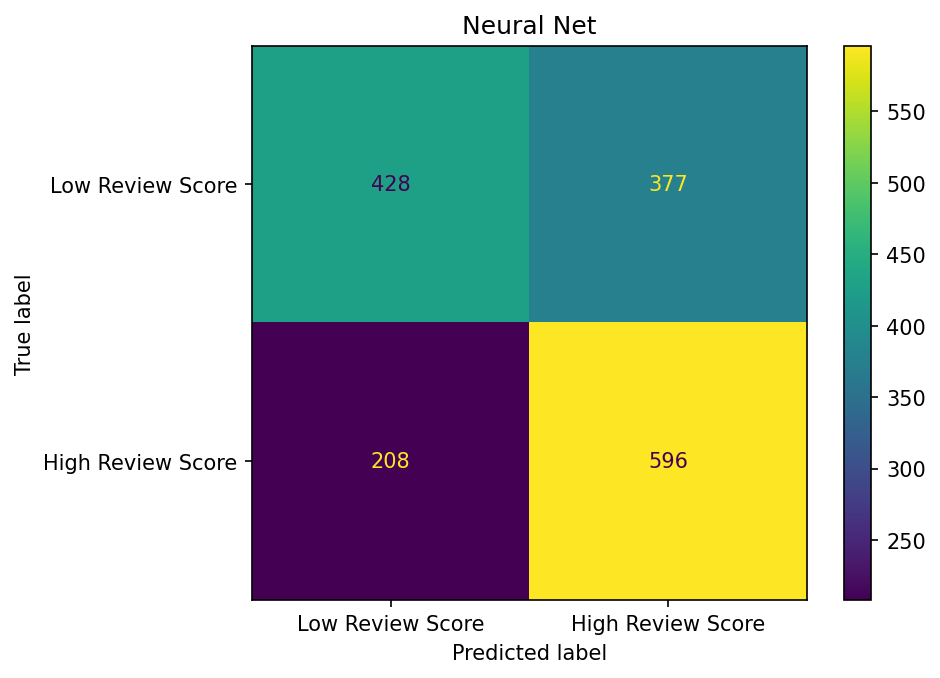

In [11]:
pred = cls.predict(X_test.values)
# proba = cls.predict_proba(X_test)
# print(proba[:10])
print("Accuracy : ", accuracy_score(y_test, pred))
print("Balanced Accuracy : ", balanced_accuracy_score(y_test, pred))
print(classification_report(y_test, pred, target_names=target_names))
print(cm := confusion_matrix(y_test, pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
disp.ax_.set_title("Neural Net")


In [7]:
features = df.columns.tolist()
for index, feature_name in enumerate(features):
    print(f"{index: >2}  {feature_name}")

 0  Host Listings Count
 1  Host Total Listings Count
 2  Calculated host listings count
 3  Latitude
 4  Longitude
 5  Accommodates
 6  Bathrooms
 7  Bedrooms
 8  Beds
 9  Price
10  Weekly Price
11  Monthly Price
12  Security Deposit
13  Cleaning Fee
14  Guests Included
15  Extra People
16  Minimum Nights
17  Maximum Nights
18  Number of Reviews
19  Reviews per Month
20  Property Type_Building
21  Property Type_Unit
22  Room Type_Entire home/apt
23  Room Type_Private room
24  Room Type_Shared room
25  Bed Type_Other
26  Bed Type_Real Bed
27  Cancellation Policy_flexible
28  Cancellation Policy_moderate
29  Cancellation Policy_strict
30  Host_Time
31  Review Time Span
32  High Review Score


In [8]:
from typing import List, Union

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.base import ClassifierMixin
from tqdm.notebook import trange

Number = Union[int, float, complex, np.number]


def pairplot_with_decision_regions(
    title: str,
    cls: ClassifierMixin,
    data: pd.DataFrame,
    X: pd.DataFrame,
    y: pd.DataFrame,
    X_test: pd.DataFrame,
    feature_indices: List[int],
    feature_names: List[str],
    filler_values: List[Number],
    filler_ranges: List[Number],
) -> None:
    n = len(feature_indices)
    fig, axarr = plt.subplots(n, n, figsize=(10, 10))
    filler_values_dict = dict(enumerate(filler_values))
    filler_ranges_dict = dict(enumerate(filler_ranges))
    color_pallete = ["#2596be", "#ff7f0e", "#2ca02c"]  # sns.color_palette("tab10")
    contourf_kwargs = {"alpha": 0.2}
    scatter_kwargs = {
        "s": 12,
        "edgecolor": None,
        "alpha": 0.7,
        "marker": "o",
        "c": color_pallete,
    }
    scatter_highlight_kwargs = {
        "s": 12,
        "label": "Test data",
        "alpha": 0.7,
        "c": None,
    }
    for i in trange(n):
        for j in trange(n):
            ax = axarr[i, j]
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            index_x, index_y = feature_indices[i], feature_indices[j]
            if i == j:
                sns.kdeplot(
                    ax=ax,
                    data=data,
                    x=feature_names[i],
                    hue="High Review Score",
                    palette="tab10",
                    alpha=0.5,
                    linewidth=0,
                    multiple="stack",
                    legend=False,
                )
                ax.set(
                    xlabel=None,
                    ylabel=None,
                )
            else:
                plot_decision_regions(
                    X.values,
                    y.values,
                    clf=cls,
                    ax=ax,
                    feature_index=[index_x, index_y],
                    filler_feature_values={
                        key: filler_values_dict[key]
                        for key in filler_values_dict
                        if key != index_x and key != index_y
                    },
                    filler_feature_ranges={
                        key: filler_ranges_dict[key]
                        for key in filler_ranges_dict
                        if key != index_x and key != index_y
                    },
                    legend=0,
                    X_highlight=X_test.values,
                    scatter_kwargs=scatter_kwargs,
                    contourf_kwargs=contourf_kwargs,
                    scatter_highlight_kwargs=scatter_highlight_kwargs,
                )
            ax.tick_params(
                axis="both",
                which="both",
                bottom=False,
                left=False,
                labelbottom=False,
                labelleft=False,
            )
            if i == n - 1:
                ax.set(xlabel=" ".join(feature_names[j].split("_")[:2]))
                ax.tick_params(
                    axis="x",
                    which="both",
                    bottom=True,
                    labelbottom=True,
                )
            if j == 0:
                ax.set(ylabel=" ".join(feature_names[i].split("_")[:2]))
                ax.tick_params(
                    axis="y",
                    which="both",
                    left=True,
                    labelleft=True,
                )
    handles, labels = axarr[0, 1].get_legend_handles_labels()

    add_legend(fig, handles, ["0", "1", "Test data"])

    fig.suptitle(f"Decision Boundary for\n{title}", size="xx-large")
    plt.show()


def add_legend(fig, handles, labels):
    # https://github.com/mwaskom/seaborn/blob/bfbd6ad5b9717db42e302177d867b4a273df162b/seaborn/axisgrid.py#L89
    figlegend = fig.legend(handles, labels, loc="center right")

    # See https://github.com/matplotlib/matplotlib/issues/19197 for context
    fig.canvas.draw()
    if fig.stale:
        try:
            fig.draw(fig.canvas.get_renderer())
        except AttributeError:
            pass

    legend_width = figlegend.get_window_extent().width / fig.dpi
    fig_width, fig_height = fig.get_size_inches()
    fig.set_size_inches(fig_width + legend_width, fig_height)

    # Draw the plot again to get the new transformations
    fig.canvas.draw()
    if fig.stale:
        try:
            fig.draw(fig.canvas.get_renderer())
        except AttributeError:
            pass

    # Now calculate how much space we need on the right side
    legend_width = figlegend.get_window_extent().width / fig.dpi
    space_needed = legend_width / (fig_width + legend_width)
    margin = 0.01
    space_needed = margin + space_needed
    right = 1 - space_needed

    # Place the subplot axes to give space for the legend
    fig.subplots_adjust(right=right)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

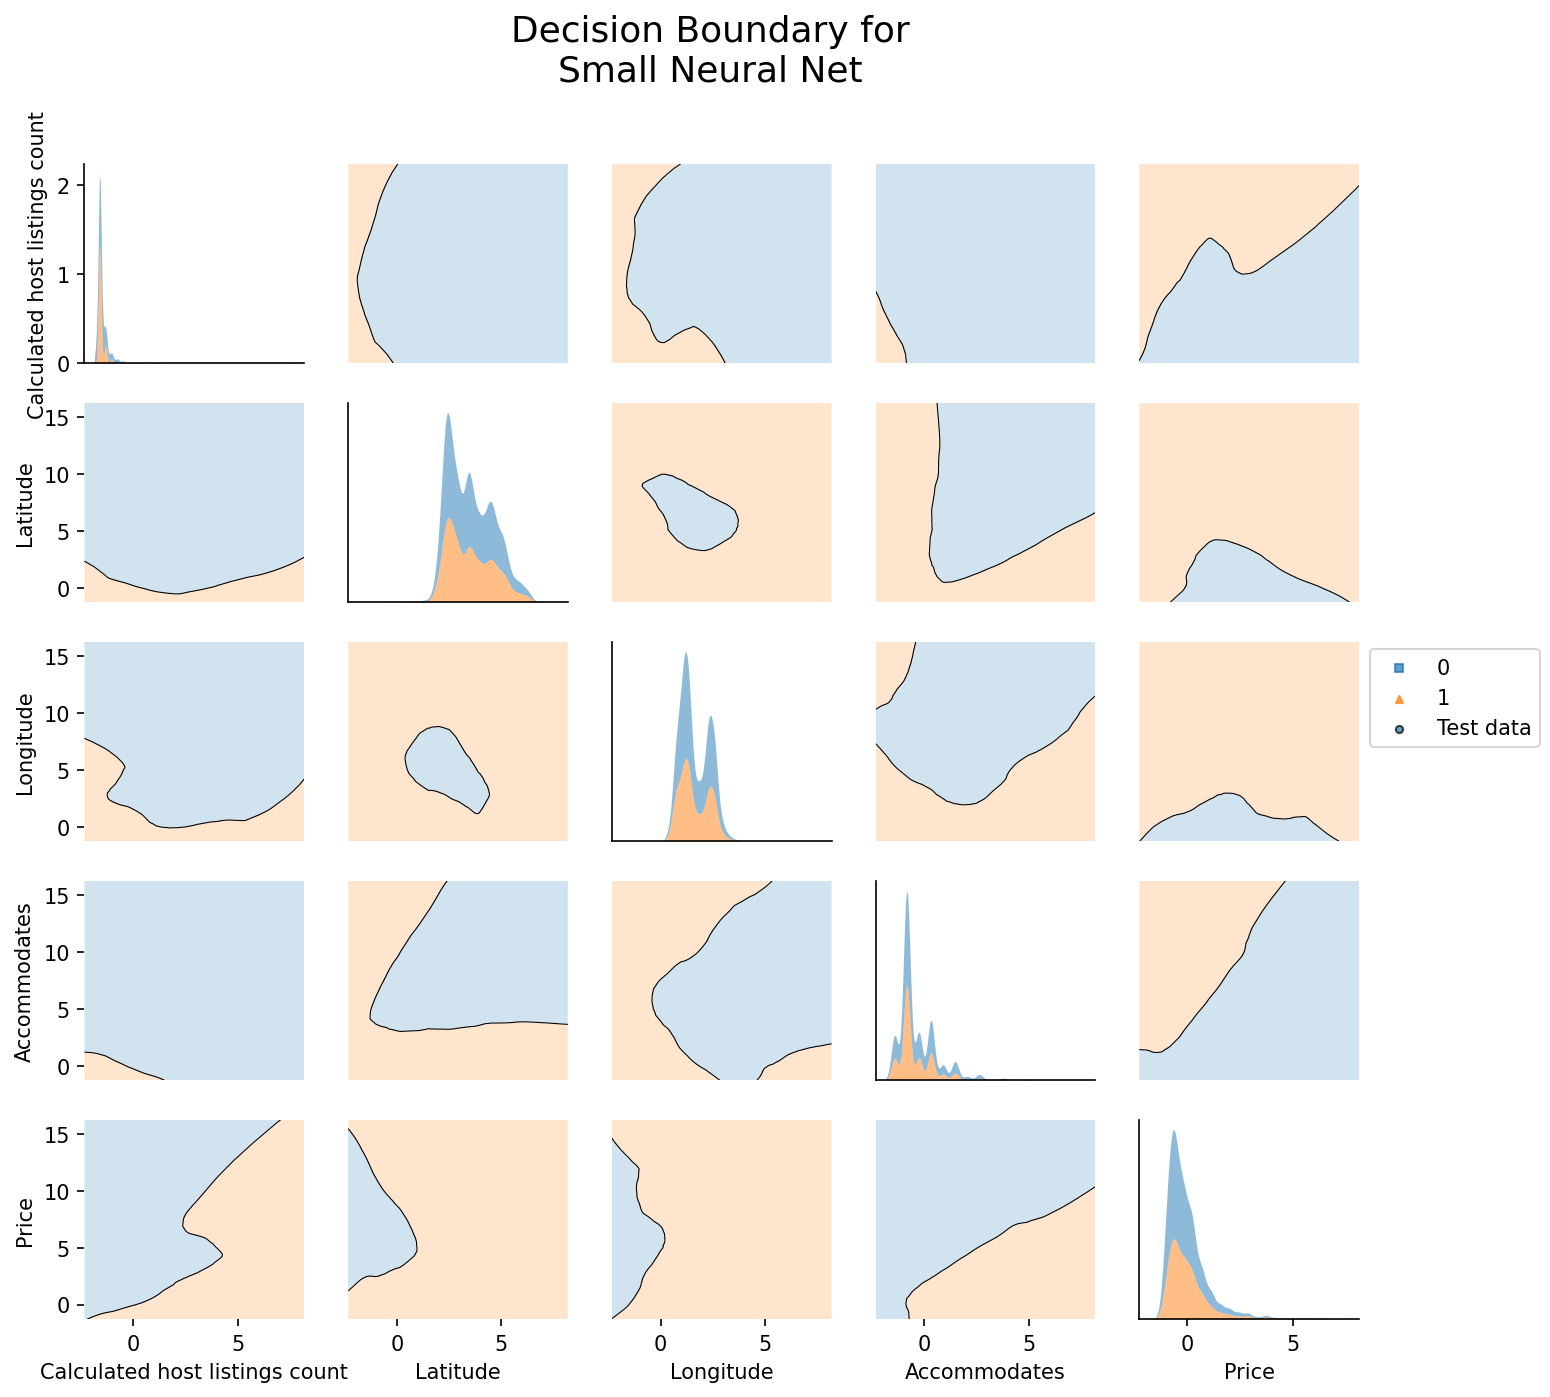

In [9]:
pairplot_with_decision_regions(
    "Small Neural Net",
    cls,
    df,
    X,
    y.astype(int),
    X_test,
    feature_indices=[
        2,
        3,
        4,
        5,
        9,
    ],
    feature_names=[
        "Calculated host listings count",
        "Latitude",
        "Longitude",
        "Accommodates",
        "Price",
    ],
    filler_values=[0] * (len(features) - 1),
    filler_ranges=[1] * (len(features) - 1),
)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

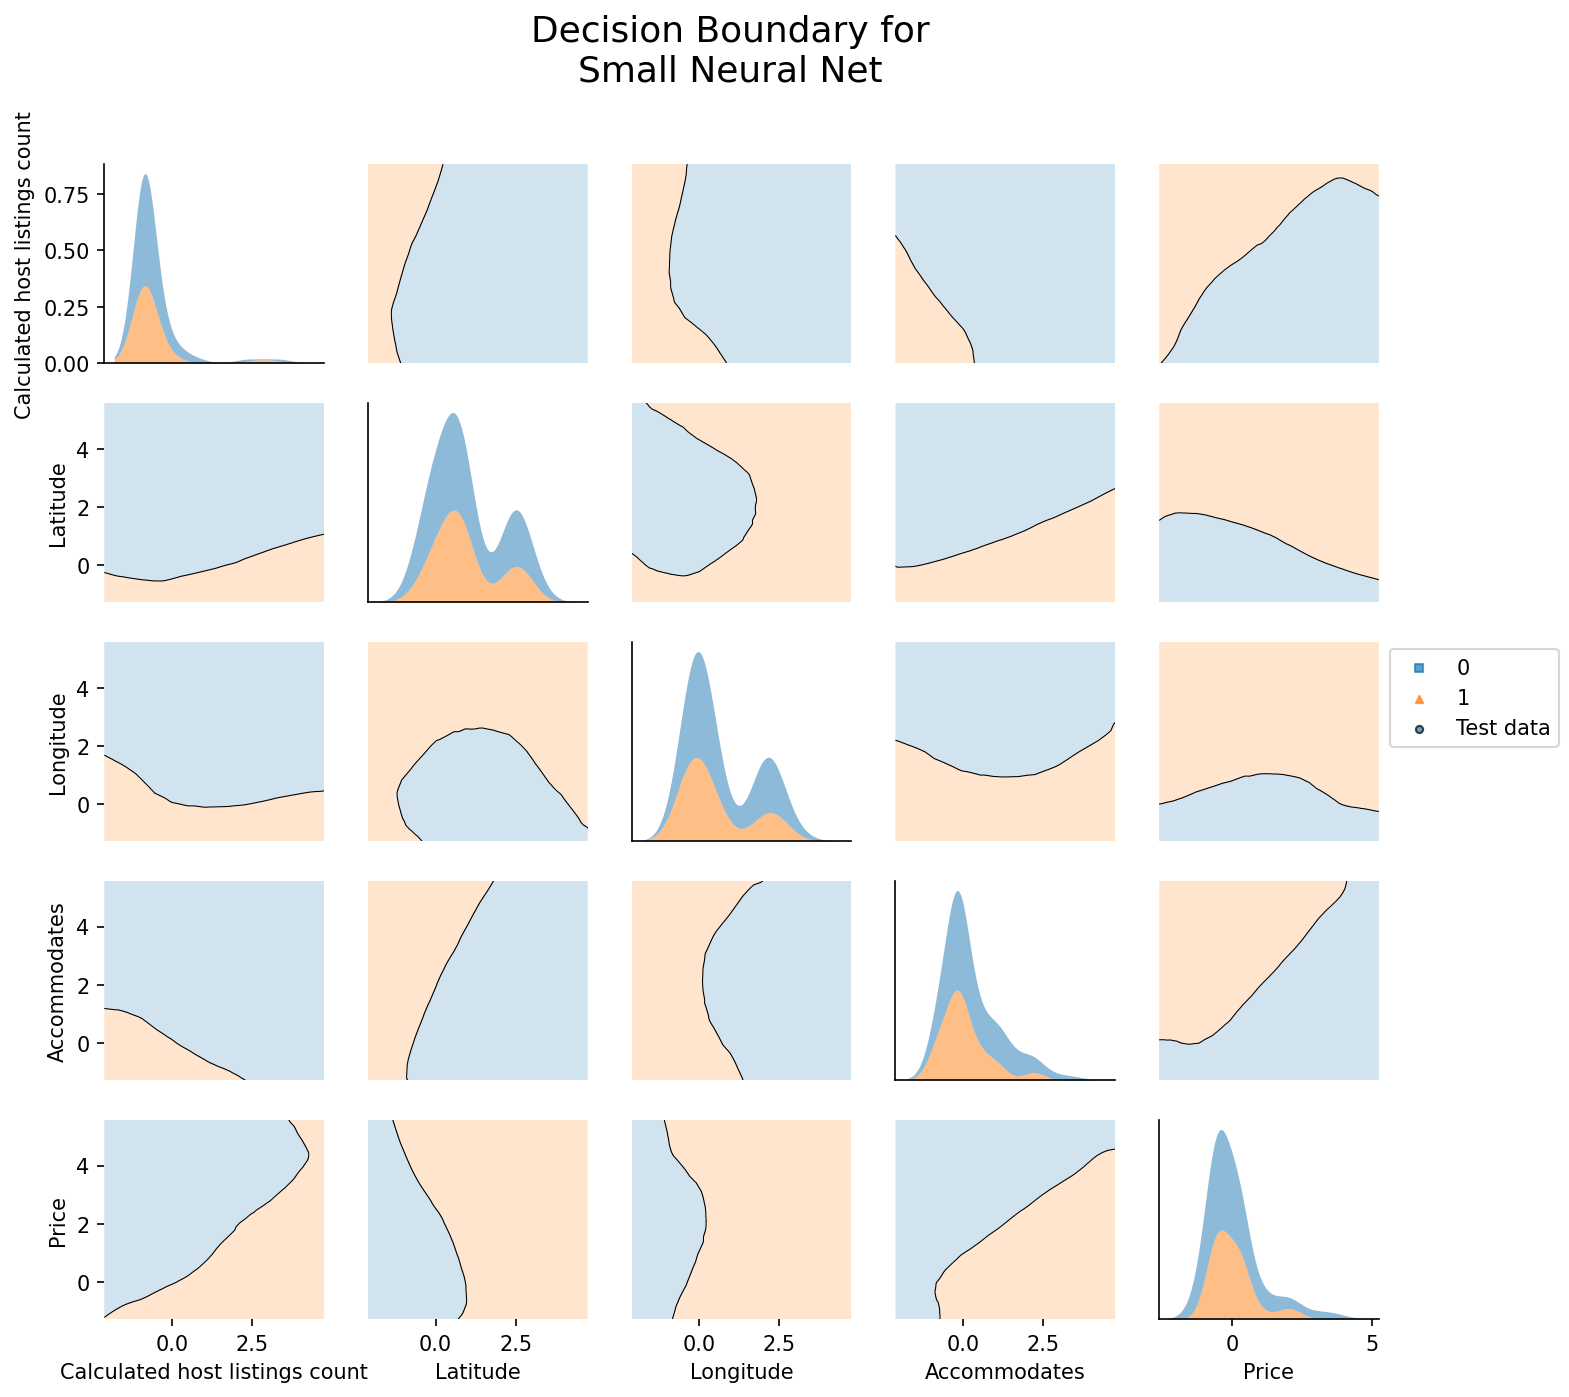

In [10]:
pairplot_with_decision_regions(
    "Small Neural Net",
    cls,
    df.head(100),
    X[:100],
    y[:100].astype(int),
    X_test[:10],
    feature_indices=[
        2,
        3,
        4,
        5,
        9,
    ],
    feature_names=[
        "Calculated host listings count",
        "Latitude",
        "Longitude",
        "Accommodates",
        "Price",
    ],
    filler_values=[0] * (len(features) - 1),
    filler_ranges=[1] * (len(features) - 1),
)
